# TMA4320 - Øving 5, Iterative metoder

Dette er en liten øving som du burde kunne gjøre før du starter opp med Prosjekt 2.
Den bli veiledet i øvingstimen fredag 22.2, kl 9-10. Innleveringsfrist er fredag 1. mars.


**Oppgave 1** Vi skal løse et spesifikt ligningssystem
$$
     A \mathbf{u} = b,\quad A\in\mathbb{R}^{n\times n},\quad b\in\mathbb{R}^n
$$

med hensyn på $\mathbf{u}$ ved å bruke SOR-metoden. La $h=\frac{1}{n+1}$ og la $b_i=h^2f(x_i)$
der $f(x)$ er en funksjon definert på intervallet $x\in[0,1]$. Vi tenker oss at systemet stammer fra Poisson-problemet $-u''(x)=f(x)$ der den dobbelderiverte er erstattet med en differenseformel, og en bruker randverdier $u(0)=u(1)=0$.
Vi har da at

$$
A = \left[
\begin{array}{rrrrrrr}
2 & -1 & 0 &  \cdots & 0  \\
-1&  2 & -1    &   \ddots      & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots &\ddots & \ddots &\ddots & -1 \\
0 &\cdots & 0 & -1 & 2
\end{array} 
\right]
$$

Du kan bruke følgende verdier til å teste ut:

* $n=10$
* $f(x)=x$ som impliserer at den eksakte løsningen er $u(x) = \frac{1}{6}\,x\,(1-x^2)$ eller
$\mathbf{u}_i\,=\,ih\,(1-(ih)^2),\ i=1,\ldots,n$
* $\mathtt{tol}=$1e-5
* $\omega=1.2$
* $\mathtt{maxiter}=1000$
* $u_0=[0,\ldots,0]^T$ (numpy.zeros(n))

Bruk algoritmen beskrevet i boka på side 110 og bruk gjerne en funksjonsheader som nedenfor.
Bruk det enkle feilestimatet $\mathtt{est}=\|u^{(k+1)}-u^{(k)}\|$ (numpy.linalg.norm()).

**NB!** Du kan skrive funksjonen som *dedikert* til matrisen $A$, dvs funksjonen hardkoder at $A$ er gitt som ovenfor og behøver ikke å kunne brukes for en vilkårlig $A$.

**Kontrollspørsmål 1** Hvor mange iterasjoner trengs for å oppnå det spesifiserte stoppkriteriet ovenfor.
Denne gangen angir du ditt resultat (ikke flervalg).

**Oppgave 2** For tilfellet $n=30$, $f(x)=-\sin x\ln x$, $\mathtt{tol}=$1e-5, $u_0=[0,\ldots,0]^T$, prøv deg fram for å finne hvilken $\omega$ som gjør at iterasjonen konvergerer raskest.

**Kontrollspørsmål 2:** Angi din optimale $\omega$ med 2 gjeldende siffer (dvs f.eks. 1.3). Du kan nøye deg med å søke etter $\omega$-verdier i intervallet $[1,2]$. Her angir du også verdi (ikke flervalg).


**Godkjenningskrav**
En Jupyter notebook fil med funksjon som implementerer SOR-metoden som spesifisert skal lastes opp i Bb og det skal svares på kontrollspørsmål.



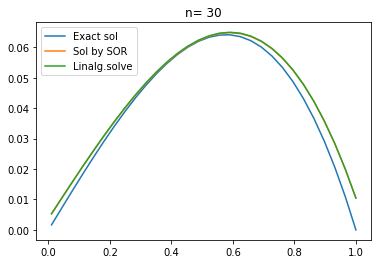

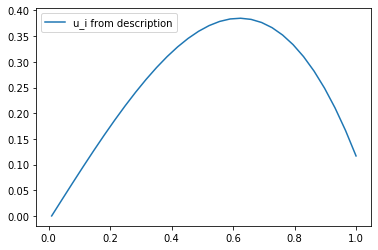

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import warnings 
#warnings.filterwarnings("ignore")

def forward_subs(LU,b):
    ''' Forover substitusjonsalgoritme
    Input:
        LU inneholder både L og U, selv om kun L trengs i denne rutinen
        b Vektor med høyresiden i problemet som skal løses
    Output:
        u Løsningen av det lineære nedretriangulære systemet Lc=b
    '''
    n, m = LU.shape
    u = np.zeros(n)
    u[0] = b[0]/LU[0,0]
    for i in range(1,n):
        u[i] = (b[i]-LU[i,:i] @ u[:i])/LU[i,i]
        
    return u

#Functions used in the Poisson-problem
def f(x):
    return x

def f2(x):
    return -np.sin(x)*np.log(x)

def ex(x):
    ''' Exact solution '''
    return (1/6)*x*(1-x**2)


#Constructs array A in the given shape
n = 30
diagonal = np.zeros(n)
diagonal.fill(2)
udiagonal = np.zeros(n-1)
udiagonal.fill(-1)
diagonals = [udiagonal, diagonal, udiagonal]
A = diags(diagonals, [-1,0,1]).toarray()

#Comstruct b . Based on the b1, it looks correct to me
h = 1/(1+n)
x = np.linspace(0.01,1,n)
b = np.full(n, (h**2*f(x))) 

def Poisson(A, b, omega,u0,tol,maxiter):
    '''
    Compute the solution to Poisson's equation in 1D by means of the SOR method. 
    Return the computed solution u.
    omega: Value of the relaxation parameter in SOR
    f: The right hand side of the Poisson equation as in -u''(x) = f(x)
    u0: The initial value for the iteration
    tol: The tolerance to be used in the stopping criterion (est < tol)
    maxiter: The maximum number of iterations
    
    '''
    k = 0
    est = 2*tol
    L = np.tril(A,-1)
    D = np.diag(np.diag(A))
    U = np.triu(A,1)
    dividend = omega*L+D
    #dividend_inv = np.linalg.inv(dividend) #This can be used for the solution without using forward_subs (numpy calculates inverse)
    while est > tol:
        k += 1   
        x = (1-omega)*(D@u0)-(omega*(U@u0))+omega*b
        #u = dividend_inv@(((1-omega)*D@u0)-(omega*(U@u0))+omega*b)
        u = forward_subs(dividend,x)
        est = np.linalg.norm(u-u0)
        if k >= maxiter:
            break
        u0 = u #Moves the iteration along
    return u

u0 = np.zeros_like(b)
omega = 1.2
tol = 1e-5
maxiter = 1000
u = Poisson(A, b, omega, u0, tol, maxiter) 

uSolve = np.linalg.solve(A,b) #bare for å sammenligne med den iterative SOR-løsningen. 

plt.plot(x, ex(x), label="Exact sol")
plt.plot(x, u, label="Sol by SOR")
plt.plot(x, uSolve, label="Linalg.solve") #Ser at SOR gjør en god jobb. Feil i dobbeltderivert-tilnærming som gjør at feilen blir stor?
plt.title("n= "+str(n))
plt.legend()
plt.show()

#Hvorfor er denne så stor? Jeg finner ikke noe feil her?
plt.plot(x, [i*h*(1-(i*h)**2) for i in range(n)], label="u_i from description")
plt.legend() 
plt.show()

**Kontrollspørsmål 1** Hvor mange iterasjoner trengs for å oppnå det spesifiserte stoppkriteriet ovenfor.
Denne gangen angir du ditt resultat (ikke flervalg).

**Mitt svar:** k = 88 iterasjoner kreves det

**Oppgave 2** For tilfellet $n=30$, $f(x)=-\sin x\ln x$, $\mathtt{tol}=$1e-5, $u_0=[0,\ldots,0]^T$, prøv deg fram for å finne hvilken $\omega$ som gjør at iterasjonen konvergerer raskest.

|$\omega$|   1.0   |   1.2   |   1.4   |   1.6   |   1.8   |   1.85  |   2.0   |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   k    |   483   |   348   |   241   |   151   |   63    |    51   | maxiter |

**Kontrollspørsmål 2:** Angi din optimale $\omega$ med 2 gjeldende siffer (dvs f.eks. 1.3). Du kan nøye deg med å søke etter $\omega$-verdier i intervallet $[1,2]$. Her angir du også verdi (ikke flervalg).

**Mitt svar:** Basert på tabellen jeg har laget ovenfor gir $\omega = 1.8$ raskest konvergens.